In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import IPython
import requests
import dotenv
import pandas as pd
import numpy as np

from backend.location import Location, spherical_distance
from backend import gmaps
from backend.grid import make_grid, Grid

dotenv.load_dotenv()

True

In [3]:
GMAPS_API_KEY = os.environ["GMAPS_API_KEY"]

In [4]:
zurich = Location(47.375, 8.5415)

prague = Location(50.07981, 14.42974)

zoom = 14
size_pixels = 640
# grid = make_grid(zurich, zoom, size=5)

Snapping to roads:   0%|          | 0/19 [00:00<?, ?it/s]

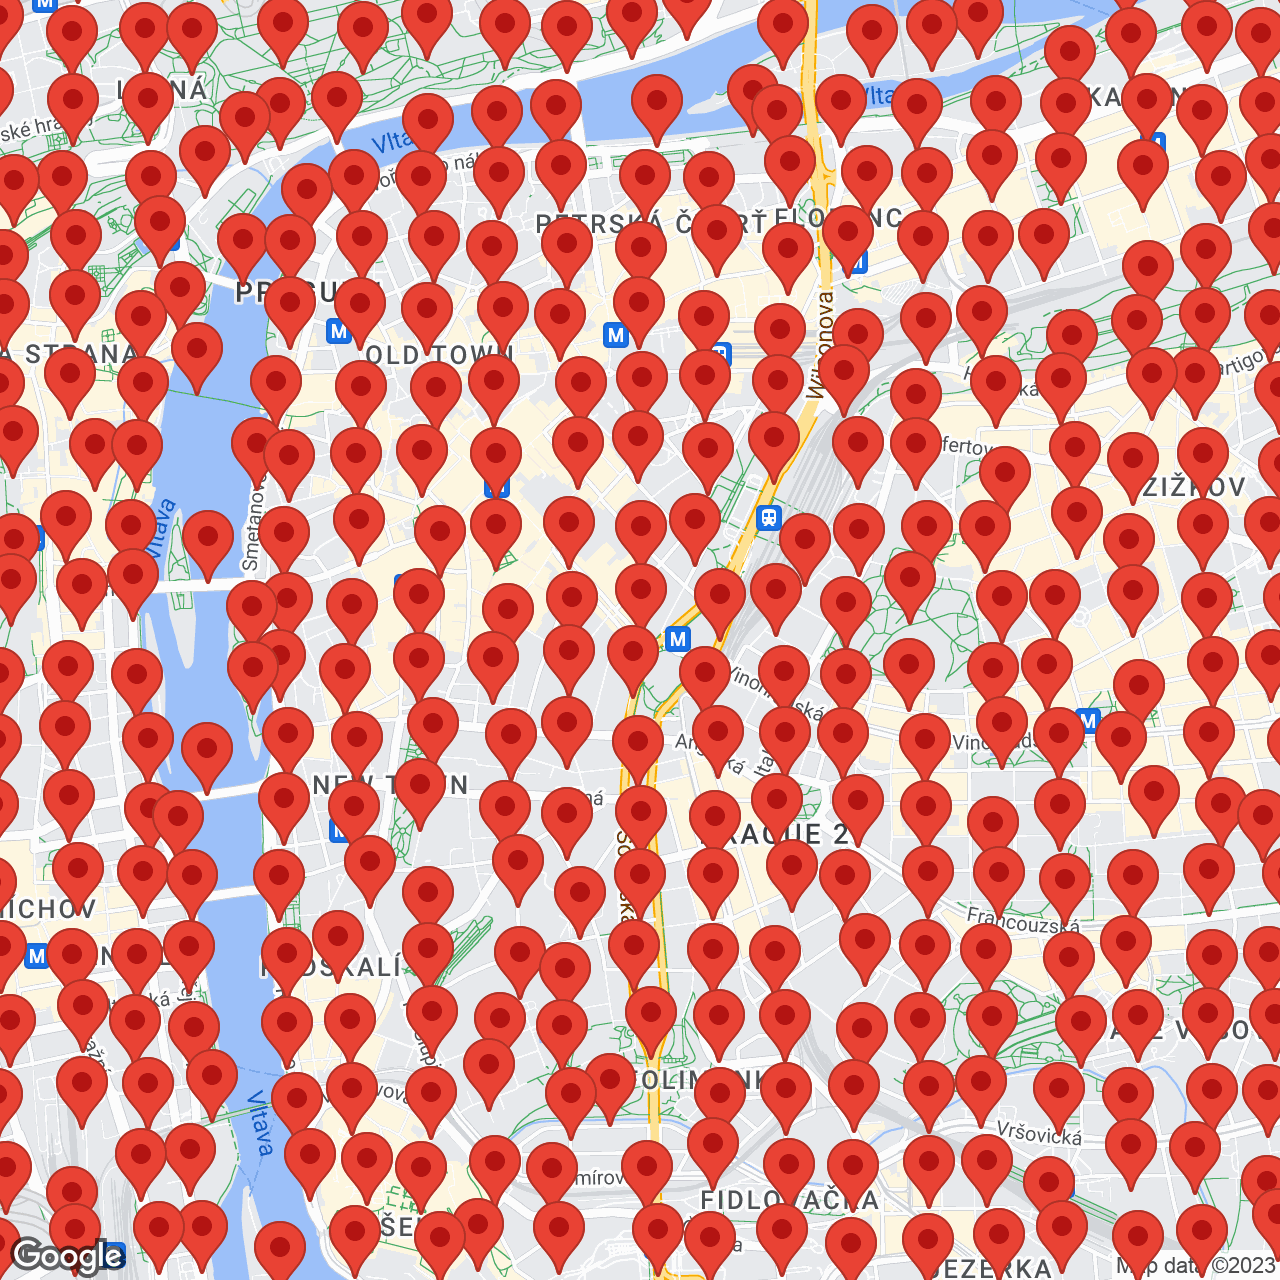

In [15]:

grid = Grid(prague, zoom=zoom, size=19, snap_to_roads=True, size_pixels=size_pixels)

image = gmaps.get_static_map(prague, zoom, markers=grid.get_snapped_locations(), size_pixels=size_pixels)
# image = gmaps.get_static_map(zurich, zoom, markers=[], size_pixels=size_pixels)
IPython.display.Image(image)

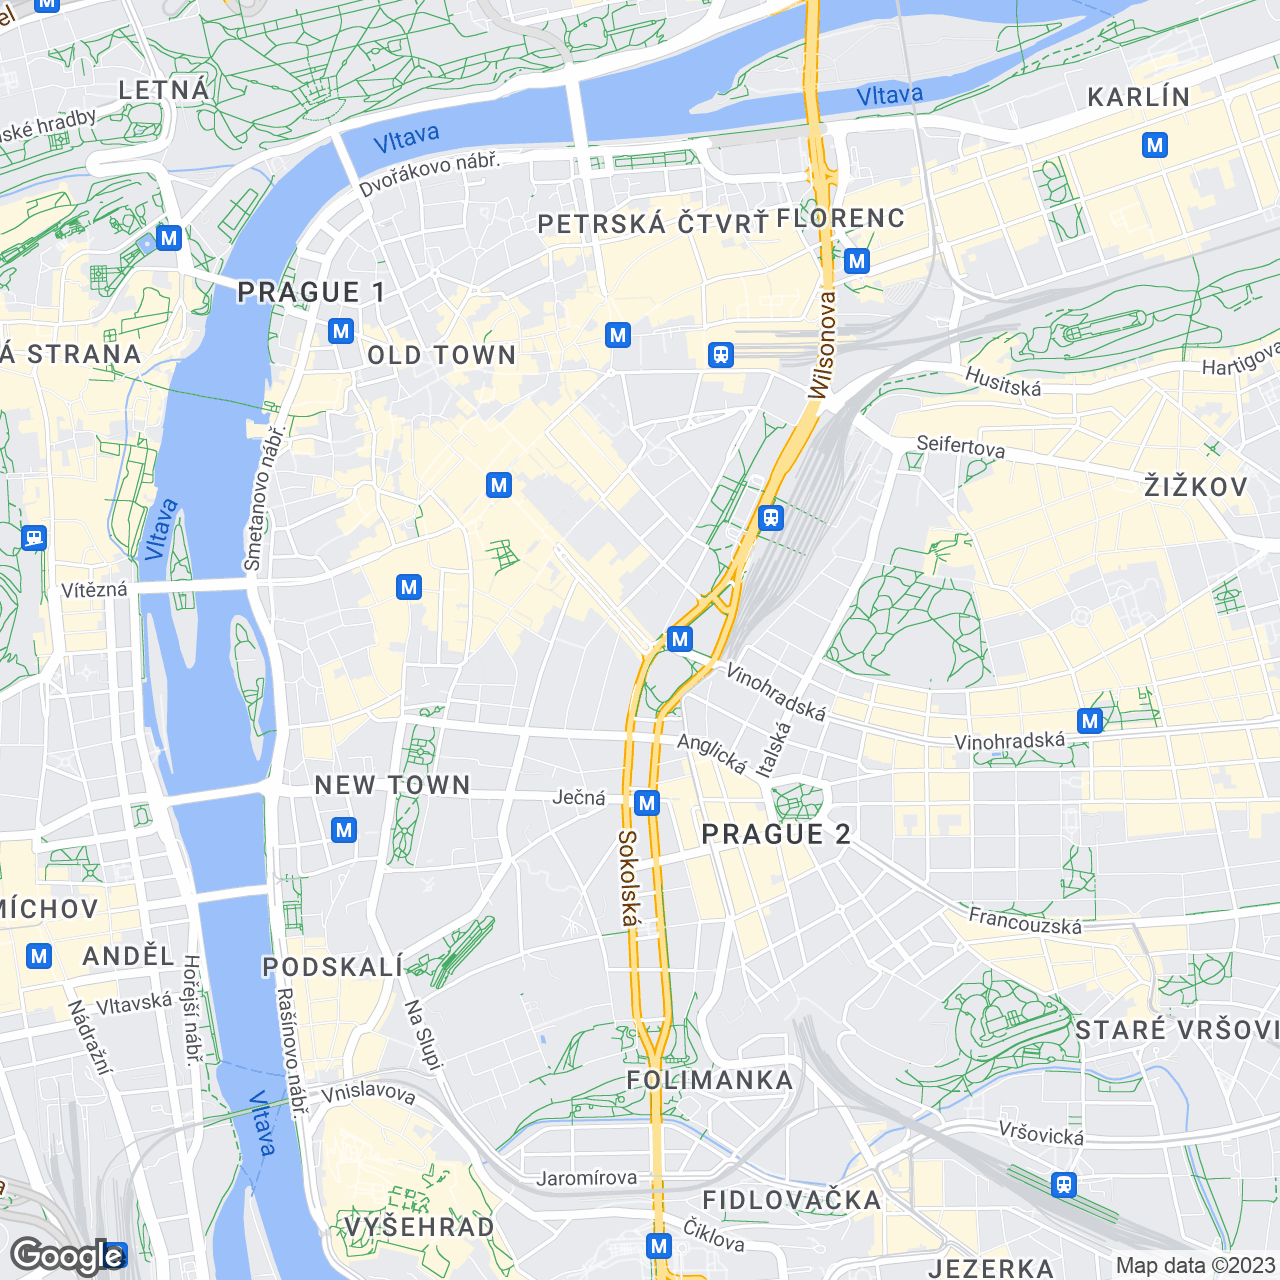

In [16]:
image = gmaps.get_static_map(prague, zoom, markers=[], size_pixels=size_pixels)
IPython.display.Image(image)

In [17]:
import logging
logging.basicConfig(level=logging.INFO)

In [18]:
grid.compute_sparsified_distance_matrix(max_normalized_distance=0.12)

Do you want to continue? [y/N]


INFO:backend.gmaps:Sparsified distance matrix has 2230 elements down from 130321.


In [19]:
with open("prague-v2.json", "w") as f:
    json.dump(grid.to_json(), f)

In [40]:
with open("20x20grid-v8.json", "w") as f:
    json.dump(grid.to_json(), f)

In [13]:
with open("15x15grid-v7.json", "w") as f:
    json.dump(grid.to_json(), f)

In [ ]:
with open("5x5matrix-v3-request.json", "w") as f:
    json.dump(gmaps.get_distance_matrix_api_payload(grid, grid), f)

In [ ]:
[x for x in matrix if "destinationIndex" not in x]

[]

## Analysis

In [ ]:
with open("../frontend/src/assets/9x9matrix-v2.json") as f:
    matrix = json.load(f)

In [ ]:
df = pd.DataFrame(matrix)
df = df.set_index(["originIndex", "destinationIndex"]).sort_index()

In [ ]:
df["durationSec"] = df["duration"].apply(lambda x: x if pd.isna(x) else int(x[:-1]))

In [ ]:
df["originLat"] = df.index.get_level_values(0).map(lambda i: grid[i].lat)
df["originLng"] = df.index.get_level_values(0).map(lambda i: grid[i].lng)
df["destinationLat"] = df.index.get_level_values(1).map(lambda i: grid[i].lat)
df["destinationLng"] = df.index.get_level_values(1).map(lambda i: grid[i].lng)

In [ ]:
df

status  distanceMeters duration     condition  \
originIndex destinationIndex                                                 
0           0                    {}             NaN       0s  ROUTE_EXISTS   
            1                    {}           476.0     123s  ROUTE_EXISTS   
            2                    {}           602.0     206s  ROUTE_EXISTS   
            3                    {}          1330.0     328s  ROUTE_EXISTS   
            4                    {}          1226.0     343s  ROUTE_EXISTS   
...                             ...             ...      ...           ...   
80          76                   {}          1539.0     376s  ROUTE_EXISTS   
            77                   {}          1444.0     298s  ROUTE_EXISTS   
            78                   {}          1404.0     290s  ROUTE_EXISTS   
            79                   {}           844.0     218s  ROUTE_EXISTS   
            80                   {}             NaN       0s  ROUTE_EXISTS   

                              durationSec  originLat  originLng  \
originIndex destinationIndex                                      
0           0                           0  47.374787   8.532955   
            1                         123  47.374787   8.532955   
            2                         206  47.374787   8.532955   
            3                         328  47.374787   8.532955   
            4                         343  47.374787   8.532955   
...                                   ...        ...        ...   
80          76                        376  47.363213   8.550045   
            77                        298  47.363213   8.550045   
            78                        290  47.363213   8.550045   
            79                        218  47.363213   8.550045   
            80                          0  47.363213   8.550045   

                              destinationLat  destinationLng  
originIndex destinationIndex                                  
0           0                      47.374787        8.532955  
            1                      47.374787        8.535091  
            2                      47.374787        8.537228  
            3                      47.374787        8.539364  
            4                      47.374787        8.541500  
...                                      ...             ...  
80          76                     47.363213        8.541500  
            77                     47.363213        8.543636  
            78                     47.363213        8.545772  
            79                     47.363213        8.547909  
            80                     47.363213        8.550045  

[6561 rows x 9 columns]

In [ ]:
df["sphericalDistance"] = df.apply(
    lambda row: spherical_distance(
        Location(row.originLat, row.originLng),
        Location(row.destinationLat, row.destinationLng),
    ),
    axis=1,
)

In [ ]:
df["distanceRatio"] =  df["sphericalDistance"] / df["distanceMeters"]
df["timeRatio"] =  df["sphericalDistance"] / df["durationSec"]

In [ ]:
df.sort_values("distanceRatio", ascending=False)

status  distanceMeters duration     condition  \
originIndex destinationIndex                                                 
65          75                   {}            33.0       4s  ROUTE_EXISTS   
75          65                   {}            33.0       5s  ROUTE_EXISTS   
78          77                   {}            28.0       6s  ROUTE_EXISTS   
77          78                   {}            28.0       3s  ROUTE_EXISTS   
            69                   {}            61.0      14s  ROUTE_EXISTS   
...                             ...             ...      ...           ...   
76          76                   {}             NaN       0s  ROUTE_EXISTS   
77          77                   {}             NaN       0s  ROUTE_EXISTS   
78          78                   {}             NaN       0s  ROUTE_EXISTS   
79          79                   {}             NaN       0s  ROUTE_EXISTS   
80          80                   {}             NaN       0s  ROUTE_EXISTS   

                              durationSec  originLat  originLng  \
originIndex destinationIndex                                      
65          75                          4  47.364660   8.537228   
75          65                          5  47.363213   8.539364   
78          77                          6  47.363213   8.545772   
77          78                          3  47.363213   8.543636   
            69                         14  47.363213   8.543636   
...                                   ...        ...        ...   
76          76                          0  47.363213   8.541500   
77          77                          0  47.363213   8.543636   
78          78                          0  47.363213   8.545772   
79          79                          0  47.363213   8.547909   
80          80                          0  47.363213   8.550045   

                              destinationLat  destinationLng  \
originIndex destinationIndex                                   
65          75                     47.363213        8.539364   
75          65                     47.364660        8.537228   
78          77                     47.363213        8.543636   
77          78                     47.363213        8.545772   
            69                     47.364660        8.545772   
...                                      ...             ...   
76          76                     47.363213        8.541500   
77          77                     47.363213        8.543636   
78          78                     47.363213        8.545772   
79          79                     47.363213        8.547909   
80          80                     47.363213        8.550045   

                              sphericalDistance  distanceRatio  timeRatio  
originIndex destinationIndex                                               
65          75                       227.527248       6.894765  56.881812  
75          65                       227.527248       6.894765  45.505450  
78          77                       160.895989       5.746285  26.815998  
77          78                       160.895989       5.746285  53.631996  
            69                       227.527248       3.729955  16.251946  
...                                         ...            ...        ...  
76          76                         0.000000            NaN        NaN  
77          77                         0.000000            NaN        NaN  
78          78                         0.000000            NaN        NaN  
79          79                         0.000000            NaN        NaN  
80          80                         0.000000            NaN        NaN  

[6561 rows x 12 columns]

In [ ]:
import plotly.express as px

In [ ]:
reindexing


{1: 1, 2: 2, 4: 4}

In [1]:
import json

In [2]:
with open("../frontend/src/assets/20x20grid-v8.json") as f:
    grid_json = json.load(f)

In [5]:
len(grid_json["locations"])

400

In [7]:
grid_json["size_pixels"] = 640

In [ ]:
with open("../frontend/src/assets/20x20grid-v8.json", "w") as f:
    json.dump(grid_json, f)